In [73]:
import os
import re
import timeit
import collections

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from bs4 import BeautifulSoup
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [16]:
data_folder = "data"
submissions_folder = os.path.join(data_folder, "submissions") 

train_file = os.path.join(data_folder, "train.csv")
test_file = os.path.join(data_folder, "test.csv")

target_names = ["Not real disaster", "Real disaster"]

stop_words = stopwords.words('english')

target_dict = {
    "label": target_names,
    "value": [0, 1]
}
target_df = pd.DataFrame(target_dict)

In [17]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [18]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
train_df.loc[:, "text"] = train_df.text.astype("string")
train_df.loc[:, "target_str"] = pd.merge(train_df, target_df, how="left", left_on="target", right_on="value")["label"]

### Data exploration

#### Target

(-1.25, 1.25, -1.25, 1.25)

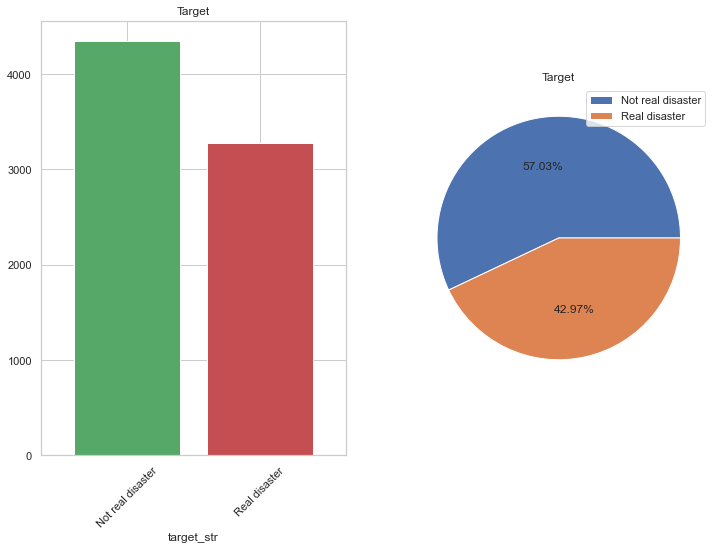

In [231]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

train_df.groupby("target_str").size().sort_values(ascending=False).plot(
    kind="bar", width=0.8, title="Target", ax=ax1, rot=45, color=["g", "r"])

train_df.groupby("target_str").size().sort_values(ascending=False).plot(
    kind="pie", title="Target", ax=ax2, legend=True, autopct="%.2f%%", labels=None)

ax2.axis("off")

#### Keyword

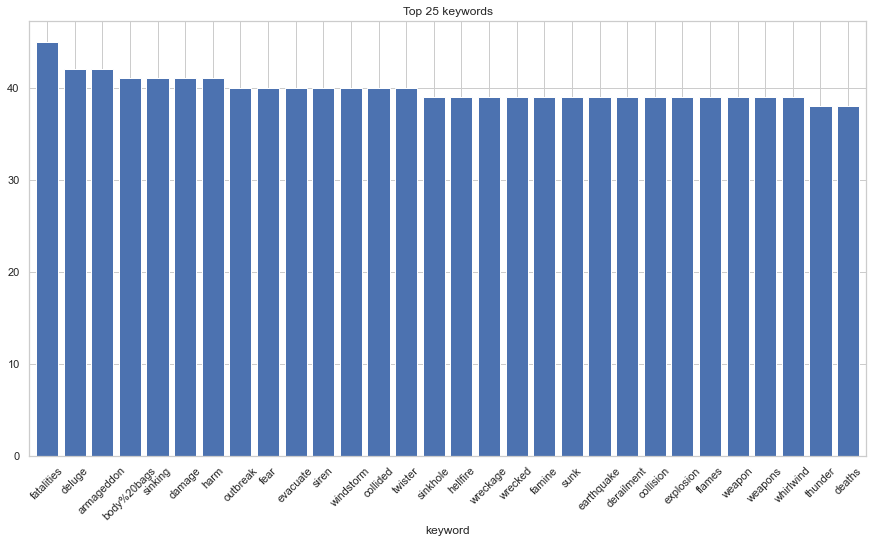

In [28]:
train_df.groupby("keyword").size().sort_values(ascending=False)[:30].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Top 25 keywords", rot=45)

#### Text
Choose randomly 5 tweets for visualize text content

In [20]:
for tweet, keyword, label in train_df[["text", "keyword", "target_str"]].sample(n=5).values:
    print(f"{keyword}\n{tweet}\n{label}\n")

lava
Shark boy and lava girl for the third time today. I guess this is what having kids feelings like. ??????
Not real disaster

bombed
@SweetieBirks @mirrorlady2 @SLATUKIP So name all the countries we've invaded/bombed aside Libya in North Africa in last 5 years.....
Real disaster

riot
@abran_caballero Discovered by @NickCannon 
 Listen/Buy @realmandyrain #RIOT on @iTunesMusic @iTunes https://t.co/dehMym5lpk Û_ #BlowMandyUp
Not real disaster

harm
I don't pray harm on members of ISIS.I pray they experience the life-rebooting love of God &amp; become 'Paul's' in Gods mind-blowing final Act
Not real disaster

detonation
Ignition Knock (Detonation) Sensor ACDelco GM Original Equipment 213-924 http://t.co/HpZHe0cjvF http://t.co/SaOhVJktqc
Not real disaster



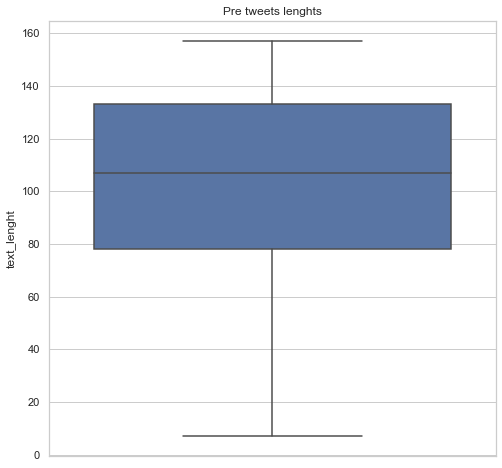

In [26]:
train_df.loc[:, "text_lenght"] = train_df.text.str.len()

fig, ax = plt.subplots(figsize=(8, 8))

sns.boxplot(data=train_df, y="text_lenght", ax=ax)
_ = ax.set_title("Pre tweets lenghts")

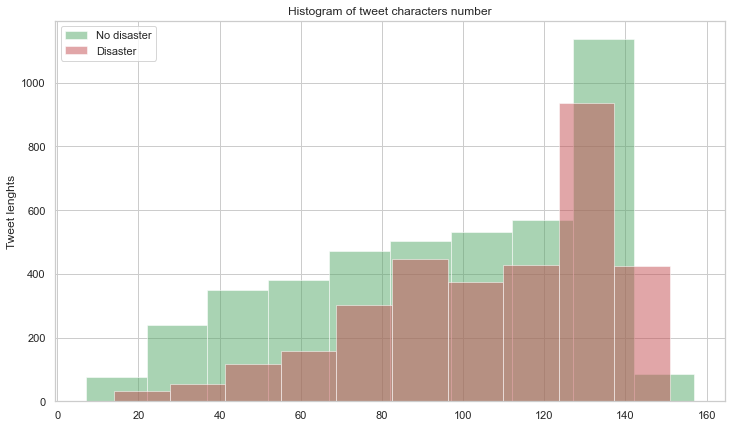

In [63]:
no_disaster_hist = train_df[train_df.target == 0].text_lenght
disaster_hist = train_df[train_df.target == 1].text_lenght

fig, ax = plt.subplots(figsize=(12, 7))

kwargs = dict(alpha=0.5, bins=10)
plt.hist(no_disaster_hist, **kwargs, color='g', label='No disaster')
plt.hist(disaster_hist, **kwargs, color='r', label='Disaster')

plt.gca().set(title='Histogram of tweet characters number', ylabel='Tweet lenghts')
plt.legend()

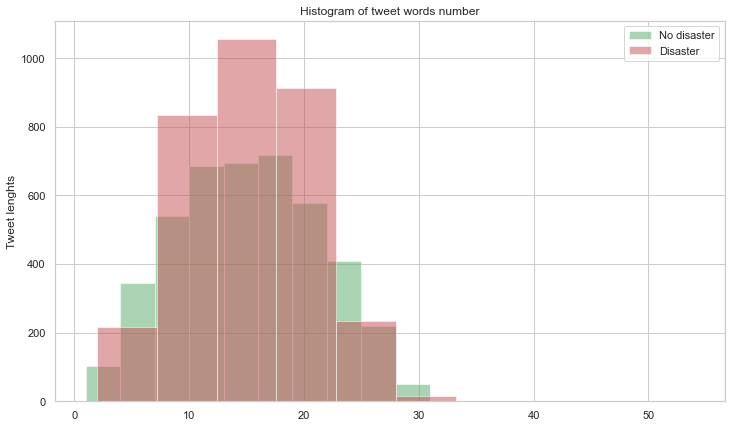

In [64]:
train_df.loc[:, "words_number"] = train_df.text.apply(lambda text: len(text.split(" ")))
no_disaster_hist = train_df[train_df.target == 0].words_number
disaster_hist = train_df[train_df.target == 1].words_number

fig, ax = plt.subplots(figsize=(12, 7))

kwargs = dict(alpha=0.5, bins=10)
plt.hist(no_disaster_hist, **kwargs, color='g', label='No disaster')
plt.hist(disaster_hist, **kwargs, color='r', label='Disaster')

plt.gca().set(title='Histogram of tweet words number', ylabel='Tweet lenghts')
plt.legend()

In [68]:
train_df.loc[:, "text_splited"] = train_df.text.str.split(" ")

In [101]:
corpus = [word for tweet in train_df.text_splited.values for word in tweet]

In [102]:
def generate_word_cloud(corpus, title):
    frequences_dict = pd.Series(corpus).value_counts().to_dict()
    wordcloud = WordCloud().generate_from_frequencies(frequences_dict)

    fig = plt.subplots(figsize=(20, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=32)
    plt.show()

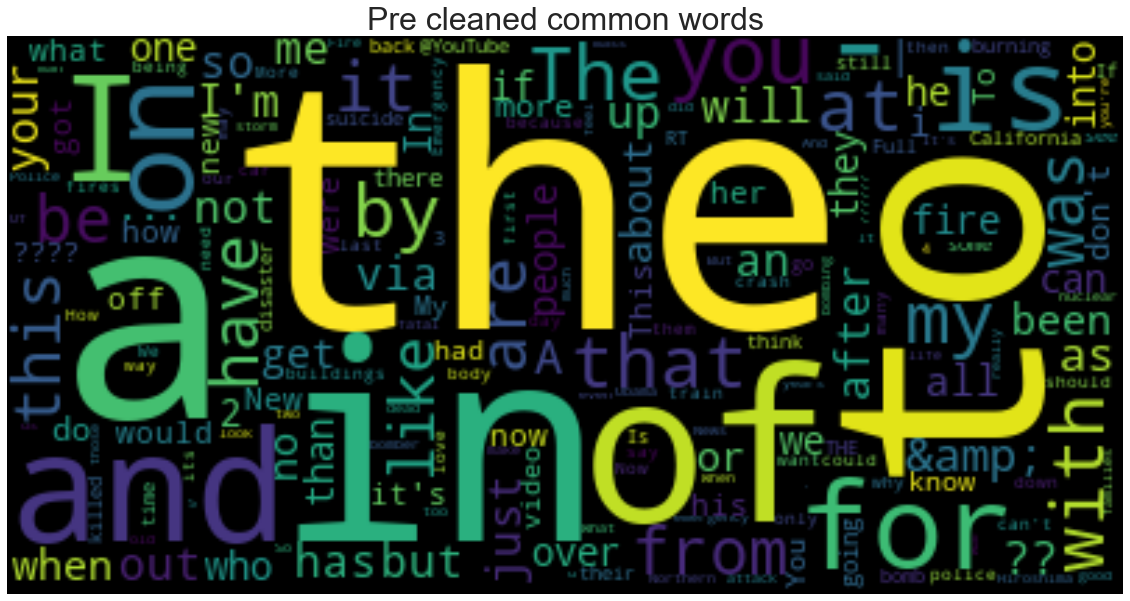

In [103]:
generate_word_cloud(corpus, "Pre cleaned common words")

#### Analyze ngrams

In [148]:
def get_top_text_n_grams(text, n_grams=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=n_grams).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq[:n]

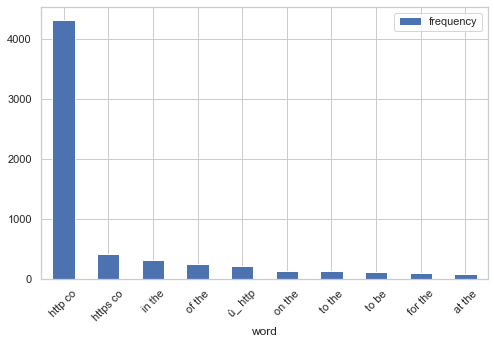

In [157]:
bigrame_df = pd.DataFrame(get_top_text_n_grams(train_df.text), columns=["word", "frequency"])

fig, ax = plt.subplots(figsize=(8, 5))
bigrame_df.head(10).plot(kind="bar", x="word", y="frequency", rot=45, ax=ax, title="Bigram frequencies")

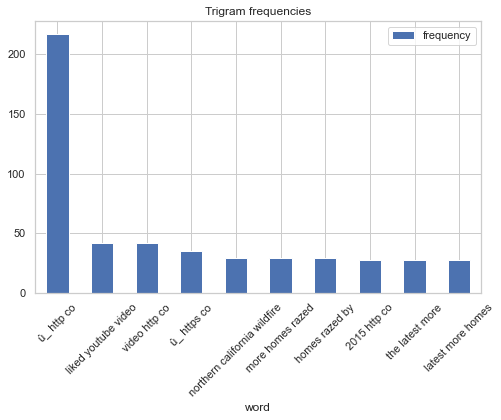

In [161]:
trigrame_df = pd.DataFrame(get_top_text_n_grams(train_df.text, n_grams=(3, 3)), columns=["word", "frequency"])

fig, ax = plt.subplots(figsize=(8, 5))
trigrame_df.head(10).plot(kind="bar", x="word", y="frequency", rot=45, ax=ax, title="Trigram frequencies")

### Data Cleaning

In [223]:
def clean_html_encoding(text):
    text = BeautifulSoup(text, 'lxml').get_text()
    return text

def remove_html_tags(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_urls(text):
    links_reg = re.compile(r'https?://[A-Za-z0-9./]+')
    return links_reg.sub(r'', text)

def remove_mentions(text):
    mentions_reg = re.compile(r'@[A-Za-z0-9]+')
    return mentions_reg.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_puntuation(tokens):
    return [token for token in tokens if token.isalpha()]
    
def remove_stop_words(tokens):
    return [token for token in tokens if token not in stop_words]

def lower_text(text):
    return text.lower()

def clean_text(text, return_list=True):
    text = clean_html_encoding(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_emoji(text)
    
    text = lower_text(text)
    tokens = word_tokenize(text)
    tokens = remove_puntuation(tokens)
    tokens = remove_stop_words(tokens)
    
    porter = PorterStemmer()
    tokens = [porter.stem(token) for token in tokens]
    if return_list:
        return tokens
    return " ".join(tokens)

In [224]:
cleaned_text = train_df.text.apply(clean_text, args=(False, ))

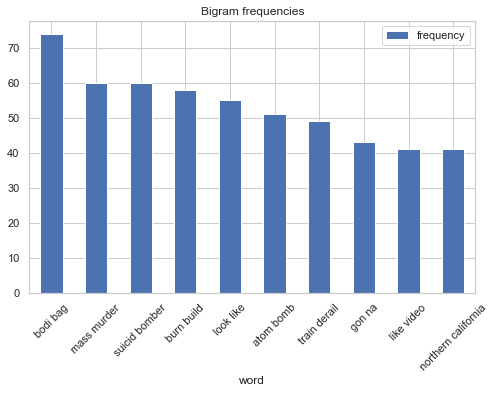

In [225]:
bigrame_df = pd.DataFrame(get_top_text_n_grams(cleaned_text), columns=["word", "frequency"])

fig, ax = plt.subplots(figsize=(8, 5))
bigrame_df.head(10).plot(kind="bar", x="word", y="frequency", rot=45, ax=ax, title="Bigram frequencies")

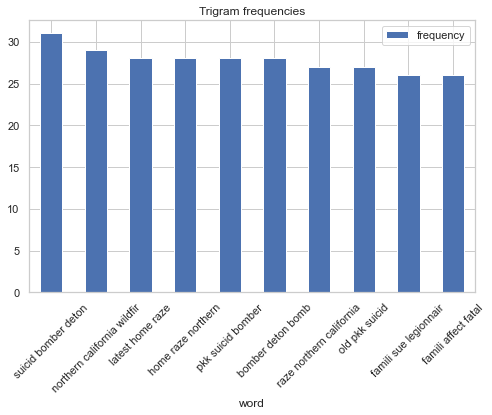

In [226]:
trigrame_df = pd.DataFrame(get_top_text_n_grams(cleaned_text, n_grams=(3, 3)), columns=["word", "frequency"])

fig, ax = plt.subplots(figsize=(8, 5))
trigrame_df.head(10).plot(kind="bar", x="word", y="frequency", rot=45, ax=ax, title="Trigram frequencies")

In [227]:
x_train, x_test, y_train, y_test = train_test_split(train_df["text"], train_df["target"], test_size=0.20, random_state=90)

In [228]:
def train_and_predict_pipeline(pipeline, x_train, y_train, x_test, y_test, target_names):
    print("\nTraining model ...")
    
    start = timeit.default_timer()
    pipeline.fit(x_train, y_train)
    stop = timeit.default_timer()
    
    training_time = stop - start
    print(f"Done!\nTraining time: {training_time}\nMaking predictions...")
    
    y_pred = pipeline.predict(x_test)
    
    accuracy = accuracy_score(y_pred, y_test)
    
    print(classification_report(y_pred, y_test, target_names=target_names))
    print(f"Confusion matrix:\n{confusion_matrix(y_pred, y_test)}")
    print(f"\nAccuracy: {accuracy}")
    print("-"*20)
    
    return training_time, accuracy

In [230]:
pipelines = list()

pipeline_bayes = Pipeline([
    ("bow", CountVectorizer(analyzer=clean_text, ngram_range=(2, 2))),
    ("tfidf", TfidfTransformer()),
    ("classifier", MultinomialNB())
])
pipelines.append(("Naivy Bayes", pipeline_bayes))

pipeline_logistic = Pipeline([
    ("bow", CountVectorizer(analyzer=clean_text, ngram_range=(2, 2))),
    ("tfidf", TfidfTransformer()),
    ("classifier", LogisticRegression())
])
pipelines.append(("Logistic Regression", pipeline_logistic))

pipeline_ridge = Pipeline([
    ("bow", CountVectorizer(analyzer=clean_text, ngram_range=(2, 2))),
    ("tfidf", TfidfTransformer()),
    ("classifier", RidgeClassifier())
])
pipelines.append(("Ridge", pipeline_ridge))

pipeline_svm = Pipeline([
    ("bow", CountVectorizer(analyzer=clean_text, ngram_range=(2, 2))),
    ("tfidf", TfidfTransformer()),
    ("classifier", SVC())
])
pipelines.append(("SVM", pipeline_svm))

pipeline_random_forest = Pipeline([
    ("bow", CountVectorizer(analyzer=clean_text, ngram_range=(2, 2))),
    ("tfidf", TfidfTransformer()),
    ("classifier", RandomForestClassifier())
])
pipelines.append(("Random Forest", pipeline_random_forest))

results = collections.defaultdict(list)

for model, pipe in pipelines:
    print(model)
    training_time, acc = train_and_predict_pipeline(pipe, x_train, y_train, x_test, y_test, target_names)
    
    results["model"].append(model)
    results["time"].append(training_time)
    results["accuracy"].append(acc)

results_df = pd.DataFrame(results)

Naivy Bayes

Training model ...
Done!
Training time: 3.890766256000461
Making predictions...
                   precision    recall  f1-score   support

Not real disaster       0.90      0.77      0.83      1008
    Real disaster       0.65      0.83      0.73       515

         accuracy                           0.79      1523
        macro avg       0.77      0.80      0.78      1523
     weighted avg       0.81      0.79      0.80      1523

Confusion matrix:
[[779 229]
 [ 90 425]]

Accuracy: 0.7905449770190414
--------------------
Logistic Regression

Training model ...
Done!
Training time: 4.102093873999365
Making predictions...
                   precision    recall  f1-score   support

Not real disaster       0.87      0.78      0.82       975
    Real disaster       0.67      0.80      0.73       548

         accuracy                           0.79      1523
        macro avg       0.77      0.79      0.78      1523
     weighted avg       0.80      0.79      0.79      1523



### Data Cleaning

In [ ]:
def html_cleaning(text):
    # Clean html encoding
    text = BeautifulSoup(text, 'lxml').get_text()
    return text

mentions_reg = re.compile(r'@[A-Za-z0-9]+')
links_reg = re.compile(r'https?://[A-Za-z0-9./]+')

# Replace english negations
negations_dic = {"isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
                 "haven't": "have not","hasn't": "has not", "hadn't": "had not","won't": "will not",
                 "wouldn't": "would not","don't": "do not", "doesn't": "does not","didn't": "did not",
                 "can't": "can not","couldn't": "could not","shouldn't": "should not","mightn't": "might not",
                 "mustn't": "must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

porter = PorterStemmer()

def text_cleaning(text, stop_words=stop_words):
    text = html_cleaning(text)
    
    # Remove mentions
    text = re.sub(mentions_reg, "", text)
    
    # Remove url
    text = re.sub(links_reg, "", text)
    
    # lower
#     text = text.lower()
    
    # Replace english negations
#     text = neg_pattern.sub(lambda x: negations_dic[x.group()], text)
    
    # Split text into tokens
    tokens = word_tokenize(text)
    
    # Remove puntuations
    words = [word for word in tokens if word.isalpha()]
    
    # Filter stop words
    words = [word for word in words if word not in stop_words]
    
    # Stemming
    stemmed = [porter.stem(word) for word in words]
    
    return stemmed

In [ ]:
train_df.loc[:, "cleaned_text"] = train_df.text.apply(text_cleaning)

In [ ]:
train_df.loc[:, "cleaned_text_str"] = train_df.loc[:, "cleaned_text"].str.join(" ")

In [ ]:
train_df[train_df.text.str.contains("aren")].iloc[5].text

In [ ]:
train_df[train_df.text.str.contains("aren")].iloc[5].cleaned_text_str

In [ ]:
# Vell

#### Remove mentions (@username)

<b>Useful new Pandas features</b>

In [ ]:
mentions_reg = re.compile(r'@[A-Za-z0-9]+')
train_df.loc[:, "text"] = train_df.text.str.replace(mentions_reg, '')

#### Remove urls

In [ ]:
links_reg = re.compile(r'https?://[A-Za-z0-9./]+')
train_df.loc[:, "text"] = train_df.text.str.replace(links_reg, '')

#### Replace english negations

In [ ]:
negations_dic = {"isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
                 "haven't": "have not","hasn't": "has not", "hadn't": "had not","won't": "will not",
                 "wouldn't": "would not","don't": "do not", "doesn't": "does not","didn't": "did not",
                 "can't": "can not","couldn't": "could not","shouldn't": "should not","mightn't": "might not",
                 "mustn't": "must not"}

neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
train_df.loc[:, "text"] = train_df.text.apply(lambda text: neg_pattern.sub(lambda x: negations_dic[x.group()], text))

### Remove puntuation, filter stop_words and stemming

In [ ]:
porter = PorterStemmer()
def clean_text(text):
    # Split text into tokens
    tokens = word_tokenize(text)
    # Remove puntuations
    words = [word for word in tokens if word.isalpha()]
    # Filter stop words
    words = [word for word in words if word not in stop_words]
    # Stemming
    stemmed = [porter.stem(word) for word in words]
    
    return " ".join(words)

In [ ]:
train_df.loc[:, "text"] = train_df.text.apply(clean_text)

#### Convert to lowercase

In [ ]:
train_df.loc[:, "text"] = train_df.text.str.lower()

# Afegir el decoding utf-8 -> index 2729

In [ ]:
train_df[train_df.original.str.contains("arn")].iloc[5].original

In [ ]:
train_df[train_df.original.str.contains("arn")].iloc[5].text

In [ ]:
train_df.text.str.len()

#### Get only letters

In [ ]:
# letters_reg = re.compile(r'[^a-zA-Z]')
# df.loc[:, "text"] = df.text.str.replace(letters_reg, ' ')

### Data Visualitzation

### Boxplot to compare pre cleaned and cleaned lenghts

In [ ]:
train_df.loc[:, "pre_clean_len"] = train_df.text.str.len()
train_df.loc[:, "clean_len"] = train_df.cleaned_text_str.str.len()

In [ ]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.boxplot(data=train_df, y="pre_clean_len", ax=ax1)
sns.boxplot(data=train_df, y="clean_len", ax=ax2)

_ = ax1.set_title("Pre cleaned lenghts")
_ = ax2.set_title("Cleaned lenghts")

In [ ]:
def generate_word_cloud(texts, title, stop_words=stop_words):
    words = [word.lower() for text in texts for word in text if word not in stop_words]
    frequences_dict = pd.Series(words).value_counts().to_dict()
    
    wordcloud = WordCloud().generate_from_frequencies(frequences_dict)

    fig = plt.subplots(figsize=(16, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=32)
    plt.show()

In [ ]:
splited = train_df.text.str.split(" ").tolist()
generate_word_cloud(splited, "Original WordCloud")

In [ ]:
generate_word_cloud(train_df.cleaned_text, "WordCloud of processed text")

In [ ]:
generate_word_cloud(train_df[train_df.target == 0].cleaned_text, "WordCloud of NO real disater")

In [ ]:
generate_word_cloud(train_df[train_df.target == 1].cleaned_text, "Wordcloud of real disater")